In [1]:
import pandas as pd
import datetime as dt

In [2]:
# Считываем данные
reg_date=pd.read_csv('problem1-reg_data.csv', sep=';')
log_in_date = pd.read_csv('problem1-auth_data.csv', sep=';')

In [ ]:
# Пишем функцию

In [82]:
 # Вводим 6 переменных для того, чтобы ограничивать итоговую тепловую карту по когортам и периоду отображения ретеншена
def retention_rate(reg,auth,reg_start,reg_end,auth_start,auth_end):
    reg_date=reg.copy() # копируем датафреймы,чтобы не менять исходный
    log_in_date = auth.copy()
    
    reg_date['reg_date']=pd.to_datetime(reg_date.reg_ts, unit='s') # переводим формат даты из таймстампа в обычный
    reg_date.reg_date=reg_date.reg_date.dt.strftime('%Y-%m-%d') # переводим в формат год-месяц-день
    reg_date=reg_date[['uid','reg_date']] # отбираем только нужные колонки
    reg_date['reg_date']=pd.to_datetime(reg_date['reg_date']) # снова переводим в временной формат, т.к формат слетел
    reg_date=reg_date.query("@reg_start <= reg_date <= @reg_end") # ограничиваем когорты заданными переменными
    
    log_in_date['auth_date']=pd.to_datetime(log_in_date.auth_ts, unit='s') #все тоже самое только с данными авторизаций
    log_in_date.auth_date=log_in_date['auth_date'].dt.strftime('%Y-%m-%d')
    log_in_date=log_in_date[['uid','auth_date']]
    log_in_date['auth_date']=pd.to_datetime(log_in_date['auth_date'])
    log_in_date=log_in_date.query("@auth_start <= auth_date <= @auth_end") # ограничиваем период отображения ретеншена на хитмэпе
    
    logs=log_in_date.merge(reg_date, on='uid', how='left') # создаем общий датафрейм
    logs['days']= logs.auth_date - logs.reg_date # добавляем столбец с днями
    logs.days = logs.days.apply(lambda x: x.days) # приводим таймдельту к обычному целому числу
    
    df_cohorts = logs\
    .groupby(['reg_date', 'days'], as_index=False)\ # формируем когорты и количество уникальных пользователей
    .nunique('uid')\
    .rename(columns={"uid": "user_count"})
    
    pivot_df = df_cohorts.pivot(index='reg_date', columns='days', values='user_count') # создаем сводную таблицу
    users_retention = pivot_df.divide(pivot_df[0], axis=0)  # делим значения на первую колонку с кол-вом уникальных пользоватлей
    
    users_retention.insert(0, "cohort_size", pivot_df[0], False) # добавляем колонку с размером когорты
    del users_retention[users_retention.columns[1]]  # удаляем 0 день
    
    ur_style = (users_retention
    .style
    .set_caption('User retention')  # добавляем подпись
    .background_gradient(cmap='YlGn')# раскрашиваем ячейки по столбцам
    .background_gradient(subset='cohort_size',cmap='Reds')# раскрашиваем столбец с размером когорты отдельно
    .highlight_null('white')  # делаем белый фон для значений NaN
    .format("{:.2%}", na_rep="")  # числа форматируем как проценты, NaN заменяем на пустоту
    .format(formatter={('cohort_size'): "{:.0f}"}))  # столбец с размерами когорт форматируем как числа
    return ur_style

In [83]:
reg= reg_date

In [84]:
auth= log_in_date

In [90]:
reg_start='2018-06-01'

In [91]:
reg_end='2018-06-20'

In [92]:
auth_start='2018-06-01'

In [93]:
auth_end='2019-06-01'

In [94]:
retention_rate(reg,auth,reg_start,reg_end,auth_start,auth_end)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [2]:
#======================================================================================================Задание 2

In [3]:
import pingouin as pg
import seaborn as sns
import numpy as np

In [4]:
sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)

In [5]:
promotions=pd.read_csv('Проект_1_Задание_2.csv', sep=';') # считываем данные 

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [6]:
#Соотношение подписок и не подписок
#Средняя выручка

In [7]:
promotions.groupby('testgroup',as_index=False).size() # смотрим на размер групп

,testgroup,size
0,a,202103
1,b,202667


In [8]:
promotions.query("testgroup == 'a'").user_id.nunique() # смотрим на уоличество уникальных 

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


202103

In [9]:
promotions.query("testgroup == 'b'").user_id.nunique() # кол-во уникальных пользователей совпадает с группированными значениями

202667

In [10]:
promotions

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [11]:
promotions.groupby('testgroup').describe()[['revenue']] # смотрим описание колонки прибыли

revenue                                                    
              count       mean         std  min  25%  50%  75%      max
testgroup                                                              
a          202103.0  25.413720  920.768137  0.0  0.0  0.0  0.0  37433.0
b          202667.0  26.751287  287.324162  0.0  0.0  0.0  0.0   4000.0

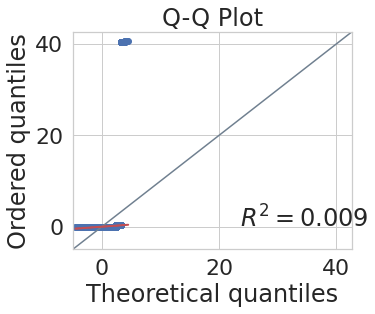

In [12]:
pg.qqplot(promotions.query("testgroup=='a'").revenue) #  проверяем нормальность распределения

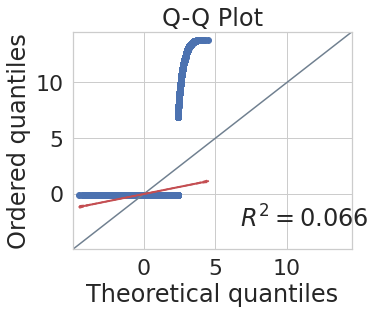

In [13]:
pg.qqplot(promotions.query("testgroup=='b'").revenue)

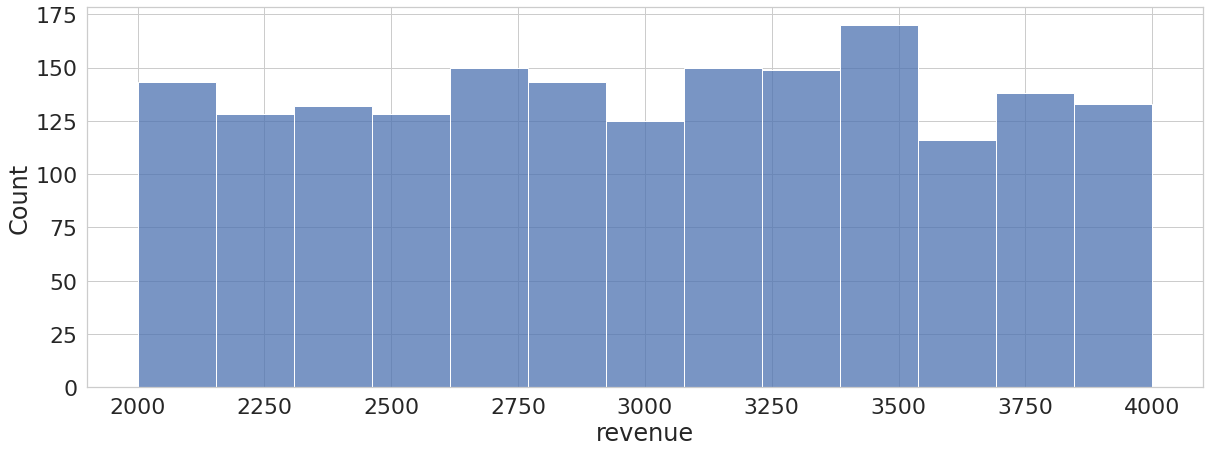

In [14]:
sns.histplot(promotions.query("testgroup=='b'and revenue != 0").revenue) # распредление платящих игроков контрольной группы

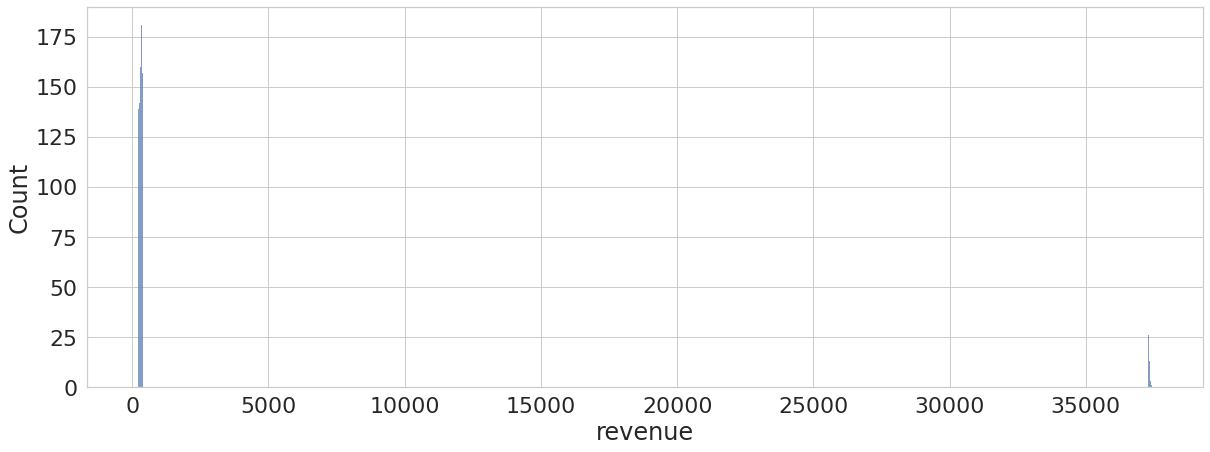

In [15]:
sns.histplot(promotions.query("testgroup=='a'and revenue != 0").revenue) # распределение платящих игороков тест группы(есть выбросы)

In [16]:
promotions.query("testgroup=='a' and revenue > 30000") # смотрим на выбросы

,user_id,revenue,testgroup
416,417,37324,a
4428,4429,37304,a
5777,5778,37315,a
8065,8066,37307,a
8743,8744,37334,a
...,...,...,...
360696,360697,37347,a
378668,378669,37297,a
389341,389342,37298,a
394580,394581,37302,a


In [17]:
#В контррольной группе 123(как раз на это количество различается количество платных пользователей) пользователя с 
#сильным отличием дохода от среднего. Из предосталвенных данных выявить была это ошибка сбора данных или нет невозможно,
#поэтому рассмотрим оба варианта 

In [18]:
#Предположим , что это была ошибка сбора данных

In [19]:
promotions_1 = promotions.query("revenue < 30000")  # берем данные без экстримальных знаяений

In [20]:
promotions_1.groupby('testgroup').describe()[['revenue']] # смотрим на описание по группам 

revenue                                                   
              count       mean         std  min  25%  50%  75%     max
testgroup                                                             
a          201980.0   2.702926   28.985815  0.0  0.0  0.0  0.0   400.0
b          202667.0  26.751287  287.324162  0.0  0.0  0.0  0.0  4000.0

In [22]:
#Проверим результаты теста на различие соотношения групп подписок и не подписок

In [23]:
promotions_1['subcription'] = (promotions_1.revenue > 0)*1

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
promotions_1.head()

,user_id,revenue,testgroup,subcription
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


In [25]:
promotions_1.groupby("testgroup",as_index=False).size()

,testgroup,size
0,a,201980
1,b,202667


In [26]:
pd.crosstab(promotions_1.testgroup, promotions_1.subcription)

subcription,0,1
testgroup,,
a,200175,1805
b,200862,1805


In [27]:
exp, obs , stats = pg.chi2_independence(data=promotions_1, x='testgroup', y='subcription') # используем метод хи квадрат для сравнения

In [28]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.007353,1.0,0.931667,0.000135,0.050843
1,cressie-read,0.666667,0.007353,1.0,0.931667,0.000135,0.050843
2,log-likelihood,0.000000,0.007353,1.0,0.931667,0.000135,0.050843
3,freeman-tukey,-0.500000,0.007353,1.0,0.931667,0.000135,0.050843
4,mod-log-likelihood,-1.000000,0.007353,1.0,0.931667,0.000135,0.050843
5,neyman,-2.000000,0.007353,1.0,0.931667,0.000135,0.050843


In [29]:
#Значение p превышает 0.05,  поэтому принимаем нулевую гиппотезу об отсутсвии различий между группами

In [30]:
#Проверим гипотезу о равенстве средней выручки в двух группах

In [31]:
promotions_1_1=promotions_1.query("revenue != 0")

In [32]:
promotions_1_1.head()

,user_id,revenue,testgroup,subcription
72,73,351,a,1
160,161,3797,b,1
341,342,290,a,1
377,378,3768,b,1
385,386,250,a,1


In [33]:
promotions_1_1.groupby('testgroup').describe()[['revenue']]

revenue                                                           \
            count         mean         std     min     25%     50%     75%   
testgroup                                                                    
a          1805.0   302.458172   57.914246   200.0   254.0   305.0   352.0   
b          1805.0  3003.658172  572.619709  2000.0  2513.0  3022.0  3478.0   

                   
              max  
testgroup          
a           400.0  
b          4000.0

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


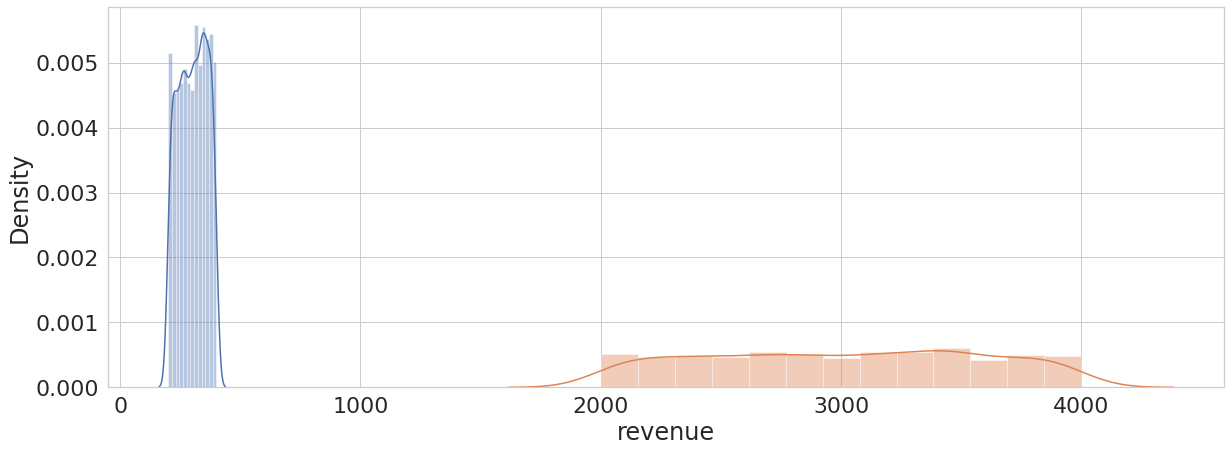

In [34]:
sns.distplot(promotions_1_1.query("testgroup == 'a'").revenue)
sns.distplot(promotions_1_1.query("testgroup == 'b'").revenue)

In [ ]:
 # будем использовать критерий Мана-Уитни так как распределения не нормальны

In [35]:
pg.mwu(promotions_1_1.query("testgroup == 'a'").revenue,promotions_1_1.query("testgroup == 'b'").revenue)

,U-val,alternative,p-val,RBC,CLES
MWU,0.0,two-sided,0.0,1.0,0.0


In [36]:
#Согласно результатам исследования в данном случае статзначинымые результаты опредленно есть, подтвержденые статистическим тестом
#Так как соотношения подписка не подписка согласно прошлому исследованию одинаковы, различия в среднем чеке доказывают их
# значимые различия. Раскатывать обновление на всех пользователей нужно

In [37]:
#Предположим , что ошибки сбора данных не было

In [ ]:
#Проверим результаты теста на различие соотношения групп подписок и не подписок

In [39]:
promotions.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [41]:
promotions_2=promotions

In [44]:
promotions_2['subcription']=(promotions_2.revenue>0)*1

In [45]:
pd.crosstab(promotions_2.testgroup, promotions_2.subcription)

subcription,0,1
testgroup,,
a,200175,1928
b,200862,1805


In [46]:
exp, obs , stats = pg.chi2_independence(data=promotions_2, x='testgroup', y='subcription')

In [47]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,4.374730,1.0,0.036476,0.003288,0.552384
1,cressie-read,0.666667,4.374870,1.0,0.036473,0.003288,0.552397
2,log-likelihood,0.000000,4.375431,1.0,0.036461,0.003288,0.552450
3,freeman-tukey,-0.500000,4.376097,1.0,0.036446,0.003288,0.552513
4,mod-log-likelihood,-1.000000,4.376973,1.0,0.036428,0.003288,0.552596
5,neyman,-2.000000,4.379356,1.0,0.036377,0.003289,0.552821


In [ ]:
# Значение p меньше 0.05,  поэтому отклоняем нулевую гиппотезу о равентсве соотношения
# В тестовой группе соотношение платных подписок значительно меньше чем в контрольной

In [48]:
promotions_2.head()

,user_id,revenue,testgroup,subcription
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


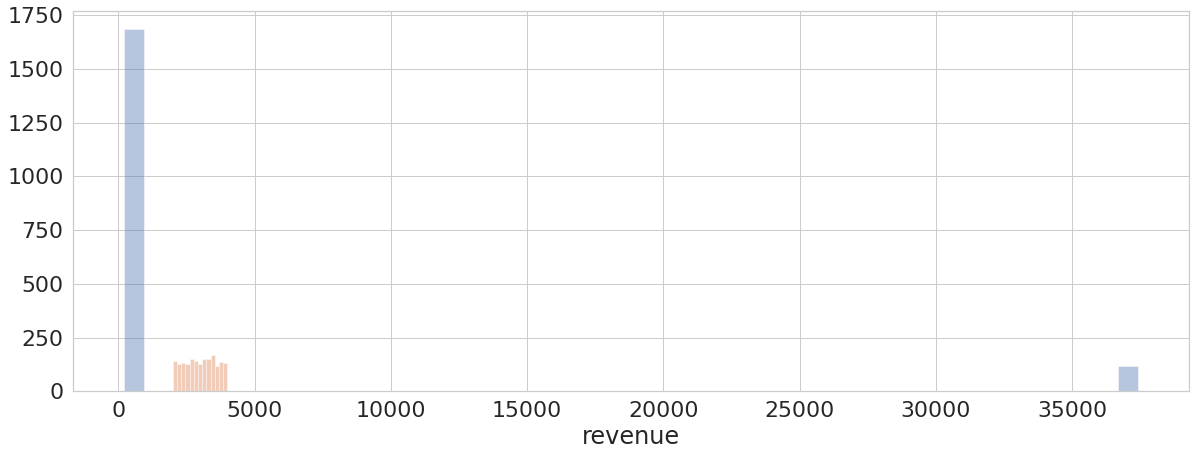

In [55]:
sns.distplot(promotions_2.query("revenue != 0 and testgroup=='a'").revenue, kde=False)
sns.distplot(promotions_2.query("revenue != 0 and testgroup=='b'").revenue, kde=False)

In [53]:
pg.mwu(promotions_2.query("revenue != 0 and testgroup=='a'").revenue, 
       promotions_2.query("revenue != 0 and testgroup=='b'").revenue)

,U-val,alternative,p-val,RBC,CLES
MWU,222015.0,two-sided,0.0,0.872407,0.063797


In [ ]:
# Данные результаты критерия Мана Уитни говорят нам о том, что вероятность взять более высокие значения из второй группы выше,
# чем из первой

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


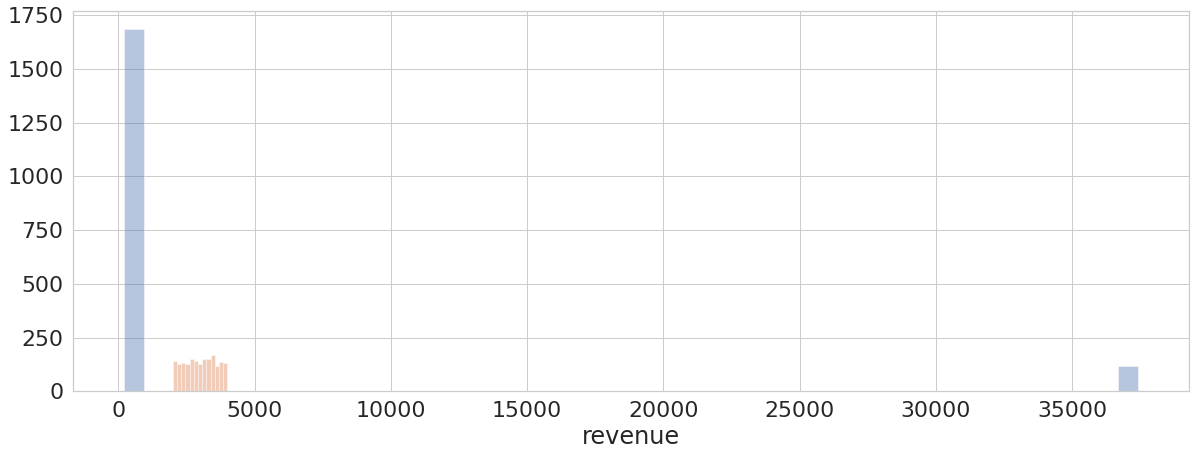

In [57]:
sns.distplot(promotions_2.query("revenue != 0 and testgroup=='a'").revenue.iloc[:1805], kde=False)
sns.distplot(promotions_2.query("revenue != 0 and testgroup=='b'").revenue.iloc[:1805], kde=False)

In [62]:
pg.compute_bootci(x=promotions_2.query("revenue != 0 and testgroup=='a'").revenue.iloc[:1805],
                  y=promotions_2.query("revenue != 0 and testgroup=='b'").revenue.iloc[:1805])

array([-0.04,  0.06])

In [81]:
mean_a = pg.compute_bootci(x=promotions_2.query("revenue != 0 and testgroup=='a'").revenue, func='mean')

In [82]:
mean_b = pg.compute_bootci(x=promotions_2.query("revenue != 0 and testgroup=='b'").revenue, func='mean')

In [83]:
mean_a

array([2260.11, 3065.86])

In [84]:
mean_b

array([2977.36, 3030.63])

In [86]:
mean_b - mean_a

array([717.25, -35.23])

In [ ]:
#Бутстрапированные средние пересекаются, поэтому сделать вывод о статзначимиом различии не можем. Бутстрап статзначимые различия
#средних не задетектировал, но критей Мана-Уитни говорит о том, что вероятность встретить бОльшие значения во второй группе выше
#чем в контрольной, но при этом соотношения подписок не подписок в тестовой группе ухудшилось 
# В дополнение к уже проведенным тестам проведем дополнительно дисперсионнный анализ
# Для этого проверим выборки на гомоскедантичность 

In [88]:
pg.homoscedasticity(promotions_2, dv='revenue', group='testgroup', method='levene')

,W,pval,equal_var
levene,0.389629,0.532495,True


In [ ]:
# Выборки имеют одинаковую диспресию, теперь проведем сам тест

In [89]:
pg.anova(data=promotions_2, dv="revenue", between="testgroup")

,Source,ddof1,ddof2,F,p-unc,np2
0,testgroup,1,404768,0.389629,0.532495,9.625973e-07


In [ ]:
# Диспресионный анализ не задетектировал статзначимых различий средних двух выборок

In [91]:
# Вывод:
#В данных наблюдаются выбросы неизвестного происхождения, которые имеют значение для проведения анализа a/b теста.Если проводить
# анализ не учитывая выбросы, то изменения значительны, тестовая группа показала  значительный положительный рост среднего 
# прибыли, при этом сохранилось отношение платящих игроков и неплатящих. Обновление можно раскатывать на всех пользователей
#
# При проведении анализа с учетом выбросов не все так однозначно. Дисперсионный анализ показал отсутствие значимых различий
# средних прибыли. Также, это было подтверждено бутстрапом.На результат сравнения средних сильное влияние оказали выбросы в данных
# Но при этом результаты критерия Мана-Уитни говорят о том, что  вероятность встретить более высокие значения в тестовой группе
# значительно выше, чем в первой. 
# Чтобы сделать более точно заключение необходимо изучить природу экстримальных значений в данных в контрольной группе, а также
# описать цель нововведений.


In [ ]:
#Задание 3

In [ ]:
#В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить
#уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней
#за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

In [ ]:
# Оценочные метрики:
# 1.Количество игроков, принявших участие в событии
# 2.Среднее количество заработанных, в рамках события, монет на игрока
# 3.Среднее количество полученных предметов на игрока
# 4.Среднее количество полученных персонажей на игрока
# 5.Среднее количсевто пройденных уровней игроками
# 6.Процент вовлеченности игроков в событие

In [ ]:
# Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок 
# будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

In [ ]:
# Набор метрик незначительно изменится. Оценочные метрики:
# 1.Количество игроков, принявших участие в событии
# 2.Среднее количество заработанных, в рамках события, монет на игрока
# 3.Среднее количество полученных предметов на игрока
# 4.Среднее количество полученных персонажей на игрока
# 5.Соотношение пройденных уровней и потерянных
# 6.Процент вовлеченности игроков в событие